## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, an A/B analysis will be performed on the e-commerce website. This analysis will help the company to decide if they should opt for a new page, stay with an old one or run the testing longer.

We will perform three types of analysis to receive a comprehensive result.


<a id='probability'></a>
#### Part I - Probability


In [63]:
# importing libraries for the whole project
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [64]:
# Read in the dataset and take a look at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


checking the number of rows in the dataset

In [3]:
df.shape[0]

294478

the number of unique users in the dataset

In [65]:
df.user_id.nunique()

290584

the proportion of users converted

In [5]:
count_converted = df[df['converted'] == 1].shape[0]
count_converted / df.shape[0]

0.11965919355605512

the number of times the `new_page` and `treatment` don't match.

In [66]:
df_inconsistent = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df_inconsistent.shape[0]

3893

checking for any missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> No null values found

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [67]:
# we should remove such rows, since we want to operate only with the data we can rely on
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index, inplace=False)

In [68]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Operating on the cleaner df2 dataframe

number of the unique **user_id**s are in **df2**

In [70]:
df2.user_id.nunique()

290584

searching for the duplicated user_id

In [71]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

viewing the whole row information for the repeat **user_id**

In [72]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [73]:
# check the number of rows before removing a duplicate
df2.shape[0]

290585

In [74]:
# since the info for the duplicated user_id is consistent, we can remove one of the duplicates
df2.drop_duplicates(subset=['user_id'], inplace=True)

# check that 1 row was removed successfully
df2.shape[0]

290584

In [75]:
# check there are no more user_id duplicates
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted


`4.`

the probability of an individual converting regardless of the page they receive

In [16]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted

In [17]:
p_control_converted = df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]
p_control_converted

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted

In [18]:
p_treatment_converted = df2.query('group == "treatment" & converted == 1').shape[0] / df2.query('group == "treatment"').shape[0]
p_treatment_converted

0.11880806551510564

the probability that an individual received the new page

In [19]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

***Conclusion for Part I***

> Based on the above, we can not conclude that the new treatment page leads to more conversions. The data shows that the convertion rate for the control group is 0.1204, what is greater than for the treatment group with the rate of 0.1188. What means that it is actually more likely to have a conversion with the control group.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Hypothesis:

> H0: **$p_{old}$** - **$p_{new}$** >= 0

> H1: **$p_{old}$** - **$p_{new}$** < 0

`2.` Assume convertion rates for **$p_{old}$** and **$p_{new}$** are the same

In [76]:
p_old_conv = df2.converted.mean()
p_old_conv

0.11959708724499628

In [77]:
p_new_conv = df2.converted.mean()
p_new_conv

0.11959708724499628

the number of individuals in the treatment group

In [22]:
n_new = df2[df2['group'] == "treatment"].shape[0]
n_new

145310

the number of individuals in the control group

In [23]:
n_old = df2[df2['group'] == "control"].shape[0]
n_old

145274

simulate a conversion rate of $p_{new}$ under the null

In [81]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [1 - p_new_conv, p_new_conv])

simulate a conversion rate of $p_{old}$ under the null

In [79]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1 - p_old_conv, p_old_conv])

difference in the convertion rates

In [82]:
new_page_converted.mean() - old_page_converted.mean()

-0.00071800913193872939

create 10,000 simulations

In [83]:
p_diffs = []

new_page_converted = np.random.binomial(n_new, p_new_conv, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old_conv, 10000) / n_old
p_diffs = new_page_converted - old_page_converted
    
p_diffs = np.array(p_diffs)    

observed difference

In [91]:
obs_diff = p_treatment_converted - p_control_converted
obs_diff

-0.0015782389853555567

plot a histogram of the **p_diffs**

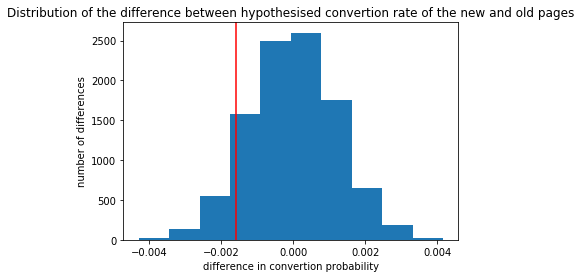

In [93]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'red');
plt.title('Distribution of the difference between hypothesised convertion rate of the new and old pages');
plt.xlabel('difference in convertion probability');
plt.ylabel('number of differences');

proportion of the **p_diffs** greater than the actual difference observed in **ab_data.csv**

In [94]:
(p_diffs > obs_diff).mean()

0.90620000000000001

> The p-value = 0.9062. It means we found the probability of observing our simulated statistic assuming null hypothesis is true. In other words, we check if our assumption was correct.

> p-value > alpha 

> 0.3896 > 0.05 thus we fail to reject the null: **$p_{old}$** = **$p_{new}$**

***Compare to built-in z-test***

calculate the number of the old and new pages that lead to convertion

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').converted.shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').converted.shape[0]

convert_old, convert_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264)

running z-test

In [32]:
# returns (test statistic for the z-test, p-value for the z-test)
# we need to use the smaller alternative based on our hypothesis testing set earlier
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = "smaller")

(1.3109241984234394, 0.90505831275902449)

**Results of the z-test**

> We found that our z-score = 1.3109, meaning that our sample mean is 1.3109 standard errors above the population mean. For alpha of 0.05, z-critical value = 1.645, what is greater than our calculated z-score. In this case we fail to reject the null hypothesis, thus convertion rate for p(old) and p(new) are equal.

> Same conclusion comes from the calculated p-value = 0.9051, what is much greater than alpha value of 0.05. We again fail to reject the null hypothesis.

> The findings from z-test agree with the findings of the bootstrapped distribution performed earlier.

***Conclusion for Part II***

The findings from both simulated distribution and z-test support the findings from Part I.

<a id='regression'></a>
### Part III - A regression approach

`1.` Logistic Regression

creating in df2 a column for the intercept, and creating a dummy variable column for which page each user received.  adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**

In [95]:
df2['intercept'] = 1

df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


using **statsmodels** to instantiate the regression model on ab_page and old_page columns, and fitting in the created model

In [96]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


summary of the fitted model

In [35]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-14 18:45 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

The p-value for ab_page is 0.1899 and it is far above alpha = 0.05. It is different from the previous p-value, because we perform a two-tailed test this time. We fail to reject the null hypothesis, meaning beta1 = 0, or p(old) = p(new).

We should consider adding a new variable into the model.

`2.` Reading the dataset with countries where each user was based at

In [97]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [98]:
# merging the countries dataset with our df2 dataset with user_id as a key
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [99]:
# checking how many dummy variables we need to create for country column
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [102]:
# creating dummy variables for the countries
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


Now we can create a model with the countries

In [101]:
lm_new = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
res_new = lm_new.fit()
res_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-14 21:01 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**Results** p-values for the countries are above 0.05, thus we again fail to reject the null. Conclusion: just the origin of the users does not affect the convertion.

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

creating the new columns

In [104]:
# creating columns to denote interraction 
df2['CA_page'] = df2['CA'] * df2['ab_page']
df2['UK_page'] = df2['UK'] * df2['ab_page']
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1,0,0


creating a new model with the interaction between pages and countries

In [105]:
lm_inter = sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK', 'CA_page', 'UK_page']])
res_inter = lm_inter.fit()
res_inter.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-14 21:04 AIC:              212782.9259
No. Observations:   290584           BIC:              212835.8241
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
CA_page      -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
UK_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**Result** As the result, we again see that all p-values are far above 0.05, thus not statistically significant. We once again fail to reject the null. There is no evidence to say that the type of page (old or new) received by users in particular countries has any impact on the convertion.

**Conclusion for Part III** 

In tact with the results from Part I and Part II, we could not find any evidence that nor the page, nor the country of the users, nor their combined value can suggest that these factors had any effect on the convertion rate.

<a id='conclusions'></a>

**Final Conclusion**

The company does not have to switch to a new page, we did not find any evidence to suggest the shift.

In [106]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0